# In this notebook, we analyze the TFT optimization results and propose hypotheses regarding the model's behavior.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

blue        = '#3b6fb6'      
green       = '#6ebe44'      
red         = '#d62728'      
error_blue  = '#1f4a7b'
error_green = '#3a7d1f'
mean_color  = '#2ca02c'

In [21]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12


df = pd.read_csv('/Users/jeanvanbeneden/Documents/Projects/electricity-forecasting/Data/Processed/tft_forecast_results.csv', parse_dates=['Date'], index_col='Date')
dfbis = pd.read_csv('/Users/jeanvanbeneden/Documents/Projects/electricity-forecasting/Data/Processed/alldata.csv') 


print(df.columns.tolist())
print(dfbis.columns.tolist())

['Actual', 'Predicted']
['Unnamed: 0', 'datetime', 'price', 'total_gen_forecast', 'total_gen_actual', 'wind_onshore_forecast', 'wind_onshore_actual', 'wind_offshore_forecast', 'wind_offshore_actual', 'solar_forecast', 'solar_actual', 'load_actual', 'load_forecast', 'gen_biomass', 'gen_gas', 'gen_hydro_river', 'gen_nuclear', 'gen_other', 'gen_solar_actual', 'gen_waste', 'year', 'forecast_error', 'wind_onshore_error', 'wind_offshore_error', 'load_error', 'hour', 'month', 'renewable_share', 'renewable_quartile', 'dayofweek', 'price_diff', 'price_lag24']


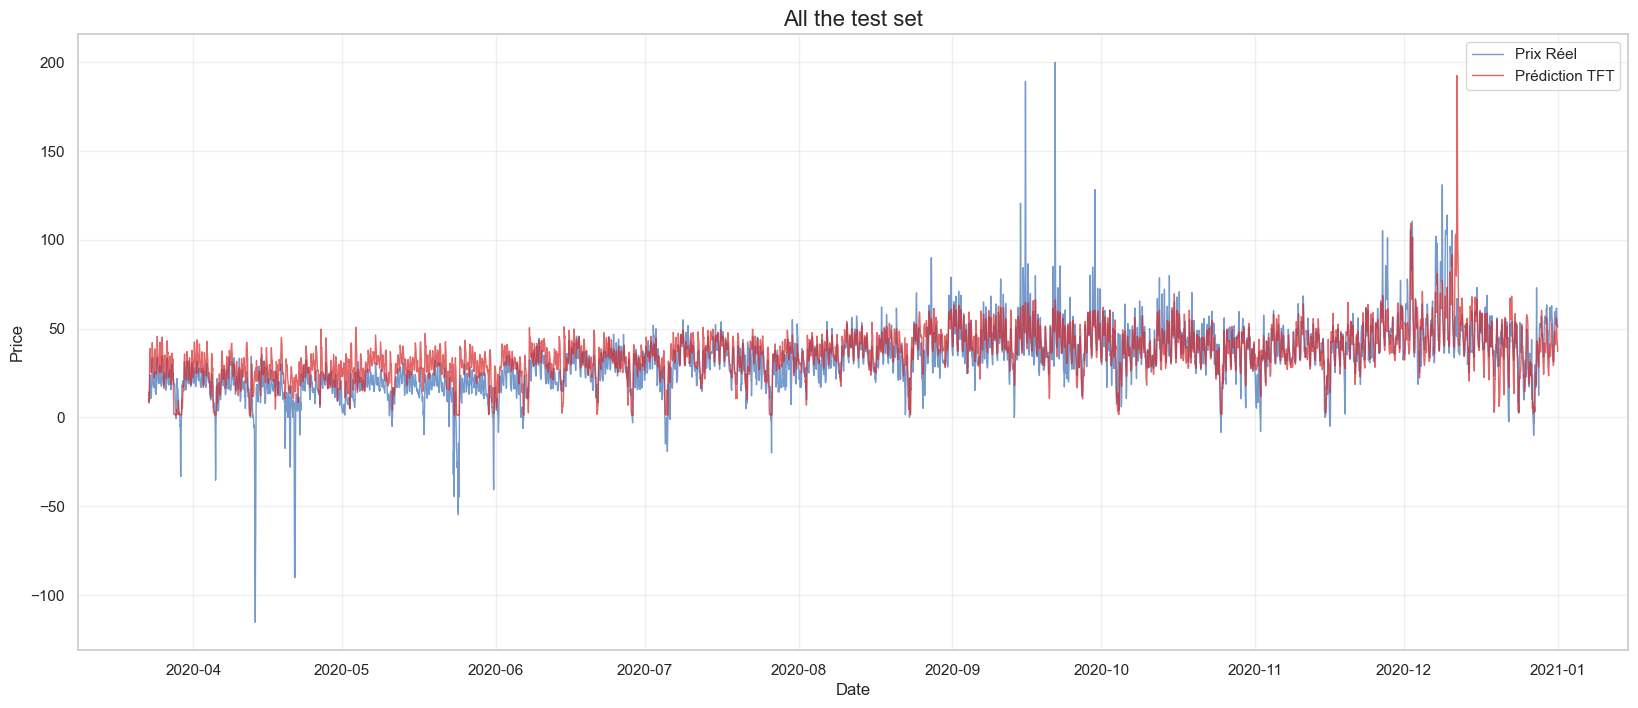

In [22]:
plt.figure(figsize=(20, 8))


plt.plot(df.index, df['Actual'], label='Prix Réel', color=blue, alpha=0.7, linewidth=1)
plt.plot(df.index, df['Predicted'], label='Prédiction TFT', color=red, alpha=0.7, linewidth=1)
plt.title("All the test set", fontsize=16)
plt.ylabel("Price", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.legend(loc='best', frameon=True)
plt.grid(True, alpha=0.3)

plt.show()

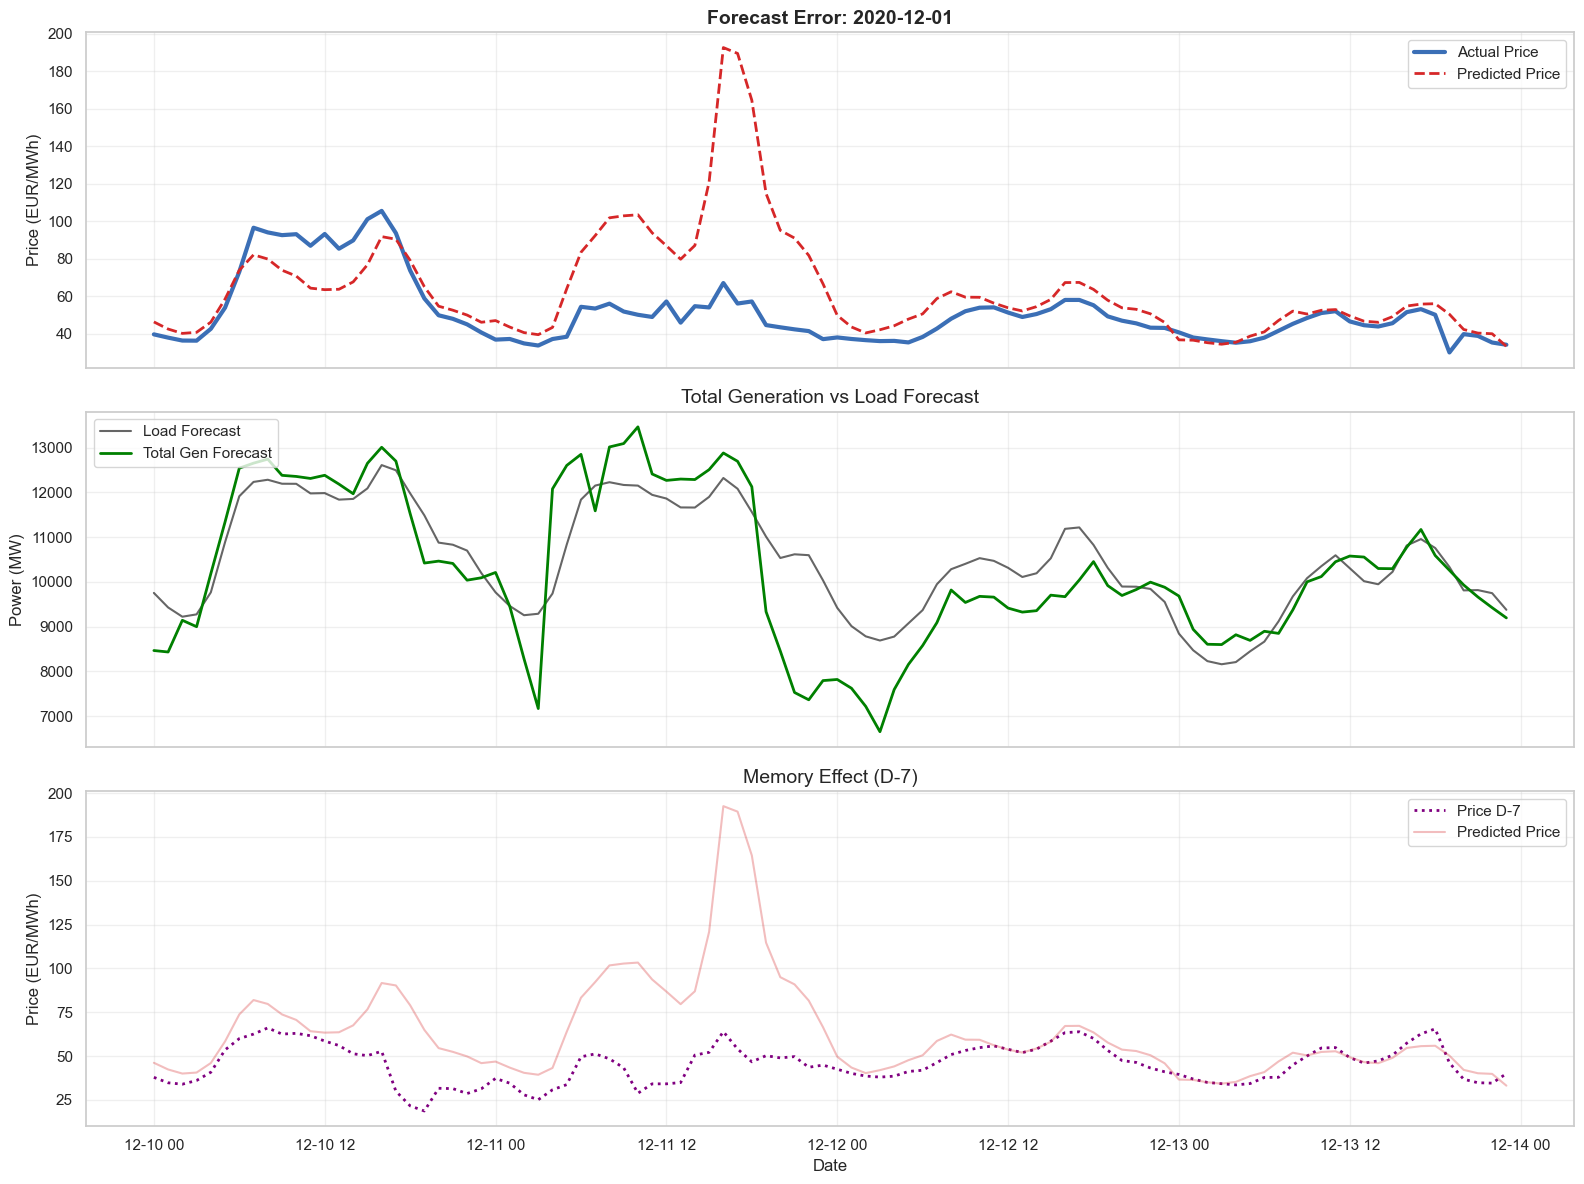

In [30]:
df_final = df.join(dfbis, how='left', rsuffix='_feat')

target_date = '2020-12-01'
start_zoom = '2020-12-10'
end_zoom = '2020-12-13'

zoom_df = df_final.loc[start_zoom:end_zoom]

fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

axes[0].plot(zoom_df.index, zoom_df['Actual'], label='Actual Price', color=blue, linewidth=3)
axes[0].plot(zoom_df.index, zoom_df['Predicted'], label='Predicted Price', color=red, linestyle='--', linewidth=2)
axes[0].set_title(f"Forecast Error: {target_date}", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Price (EUR/MWh)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(zoom_df.index, zoom_df['load_forecast'], label='Load Forecast', color='black', alpha=0.6)
axes[1].plot(zoom_df.index, zoom_df['total_gen_forecast'], label='Total Gen Forecast', color='green', linewidth=2)
axes[1].set_ylabel("Power (MW)")
axes[1].set_title("Total Generation vs Load Forecast", fontsize=14)
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)
lag_168 = df_final['Actual'].shift(168).loc[start_zoom:end_zoom]
axes[2].plot(zoom_df.index, lag_168, label='Price D-7', color='purple', linestyle=':', linewidth=2)
axes[2].plot(zoom_df.index, zoom_df['Predicted'], label='Predicted Price', color=red, alpha=0.3)
axes[2].set_title("Memory Effect (D-7)", fontsize=14)
axes[2].set_ylabel("Price (EUR/MWh)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.xlabel("Date")
plt.tight_layout()
plt.show()

### Clearly a strange phenomenon. Shows that my model lacks data : Belgium has surely import energy from other countries !

## The key will be to analyze the performance by regimes :

In [3]:
df['Error'] = df['Actual'] - df['Predicted']
df['Abs_Error'] = df['Error'].abs()
df['Sq_Error'] = df['Error']**2

df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.day_name()
df['Week'] = df.index.isocalendar().week

bins = [-np.inf, 0, 25, 75, 150, np.inf]
labels = ['Negative/Zero', 'Low', 'Normal', 'High', 'Spike (Crisis)']

df['Regime'] = pd.cut(df['Actual'], bins=bins, labels=labels)


mae = df['Abs_Error'].mean()
rmse = np.sqrt(df['Sq_Error'].mean())

print(f"MAE : {mae:.2f} EUR/MWh")
print(f"RMSE : {rmse:.2f} EUR/MWh")

MAE : 7.91 EUR/MWh
RMSE : 11.60 EUR/MWh


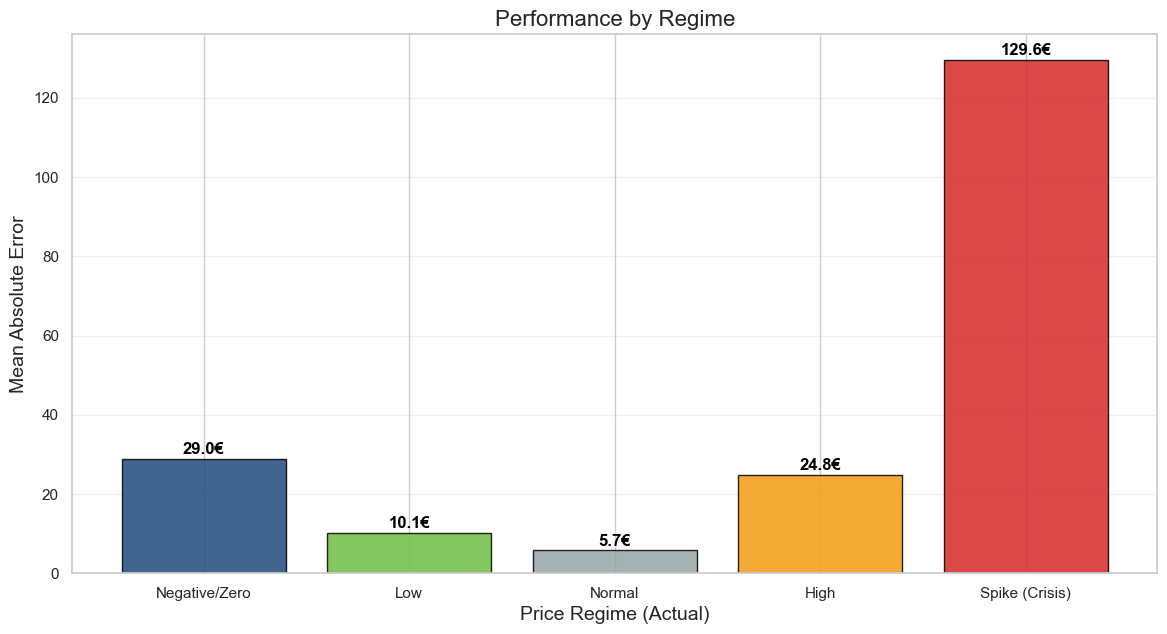

In [8]:
regime_stats = df.groupby('Regime', observed=False)['Abs_Error'].agg(['mean', 'count', 'max'])
regime_stats.columns = ['Mean MAE', 'Hours Count', 'Max Error']

plt.figure(figsize=(14, 7))

custom_palette = [error_blue, green, '#95a5a6', '#f39c12', red]

bars = plt.bar(regime_stats.index, regime_stats['Mean MAE'], color=custom_palette, alpha=0.85, edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}€', ha='center', va='bottom', fontweight='bold', color='black')

plt.title("Performance by Regime", fontsize=16)
plt.ylabel("Mean Absolute Error", fontsize=14)
plt.xlabel("Price Regime (Actual)", fontsize=14)
plt.grid(axis='y', alpha=0.3)

plt.show()

### We clearly observe a non-linear degradation of performance. 
### While the model is very accurate in the 'Normal' regime (5.7€), the error explodes by a factor of 26 during the 'Spikes'
### This suggests the statistical model fails to capture scarcity dynamics/strategic behavior.

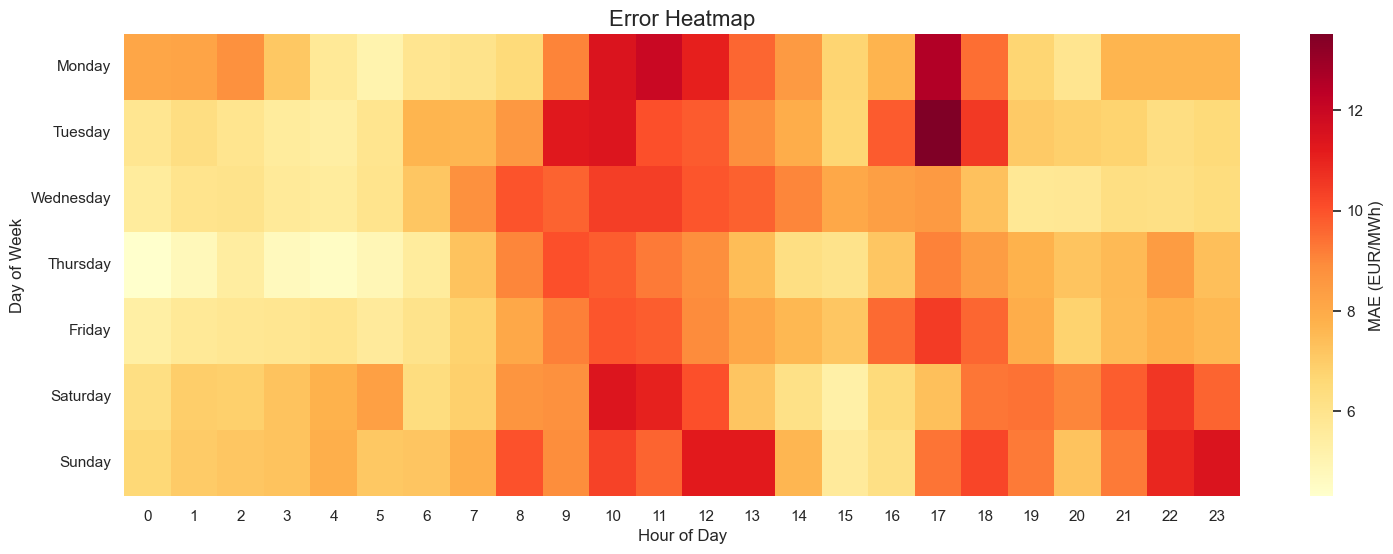

In [10]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

pivot_error = df.pivot_table(
    values='Abs_Error', 
    index='DayOfWeek', 
    columns='Hour', 
    aggfunc='mean'
)
pivot_error = pivot_error.reindex(days_order)

plt.figure(figsize=(18, 6))
sns.heatmap(pivot_error, cmap='YlOrRd', annot=False, fmt=".0f", cbar_kws={'label': 'MAE (EUR/MWh)'})

plt.title("Error Heatmap", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Day of Week", fontsize=12)
plt.yticks(rotation=0)
plt.show()

### Errors often concentrate during ramp-up hours where grid constraints force operators to make rapid strategic choices.